In [1]:
import pandas as pd
import re
import os
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

from core.orm import Base
from core.project import Project
from utils.orm import boreholes_from_dataframe
from utils.visual import legend_from_attributes
from utils.config import DEFAULT_LITHO_LEXICON, DEFAULT_POL_LEXICON, DEFAULT_LITHO_LEGEND, DEFAULT_Z
from definitions import ROOT_DIR

In [12]:
from striplog import Striplog, Interval, Component

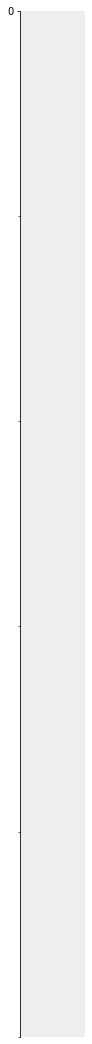

In [14]:
Striplog([Interval(top=0, base=5, components=[])]).plot()

In [2]:
def create_project(data_dict, db_name, **kwargs):
    for k,v in data_dict.items():
        if isinstance(v, str):
            data_dict[k] = pd.read_csv(v, sep=',')
        elif not isinstance(v, pd.DataFrame):
            raise(TypeError("data_dict values must be a filename (*.csv) or a dataframe!"))
            
    verbose = kwargs.pop('verbose', False)
    sample_type_col = kwargs.pop('sample_type_col', 'Type_ech')
    diameter_col = kwargs.pop('Diam_for', 0.1) 
    pollutants = kwargs.pop('pollutants', [])
    skip_cols = kwargs.pop('skip_cols', [])
    litho_legend = kwargs.pop('litho_legend', DEFAULT_LITHO_LEGEND)
    litho_lexicon = kwargs.pop('litho_lexicon', DEFAULT_LITHO_LEXICON)
    # pollutants_legend = kwargs.pop('pollutants_legend', DEFAULT_POL_LEGEND)
    pollutants_lexicon = kwargs.pop('pollutants_lexicon', DEFAULT_POL_LEXICON)
    
    r = re.compile("samp|pol", flags=re.I)
    r_list = list(filter(r.search, list(data_dict.keys())))
    if r_list: key = r_list[0]
    if not pollutants and r_list:
        for i, c in enumerate(data_dict[key].columns):
            if c in pollutants_lexicon.abbreviations.keys() or c in pollutants_lexicon.abbreviations.values():
                pollutants.append(c)
                
    default_z = kwargs.pop('default_z', DEFAULT_Z) 
    attributes=kwargs.pop('attributes', ['lithology']+pollutants)
    legend_dict = legend_from_attributes([('lithology', litho_legend)]+pollutants)
    symbols=kwargs.pop('symbols', {'lithology':{'lexicon': litho_lexicon}})
    boreholes, components, link_intv_comp = boreholes_from_dataframe(data_dict, verbose=verbose,
                                                sample_type_col=sample_type_col, diameter_col=diameter_col, 
                                                default_z=default_z, attributes=attributes, 
                                                symbols=symbols, skip_cols=skip_cols)

    if os.path.exists(db_name):
        os.remove(db_name)

    engine = create_engine(f"sqlite:///{db_name}", echo=True)
    Base.metadata.create_all(engine)
    Session = sessionmaker(bind=engine)
    session = Session()
    p = Project(session, name='Memoris_project', legend_dict=legend_dict, lexicon=DEFAULT_LITHO_LEXICON)
    p.add_components(components)
    for bh in boreholes:
        p.add_borehole(bh)
    p.add_link_components_intervals(link_intv_comp)
    p.commit()
    p.refresh()
    session.close()
    p.update_legend_cmap(compute_all_attrib=True, verbose=False)
    return p

In [3]:
from utils.io import dataframe_viewer, replicate_values, dict_viewer, find_borehole_by_position

In [8]:
a = pd.read_csv(f'{ROOT_DIR}/CF_data/Result_traitem/fusion_finale/Boreholes.csv', sep=',')
lit = pd.read_csv(f'{ROOT_DIR}/CF_data/Result_traitem/fusion_finale/Lithologies.csv', sep=',')
sp = pd.read_csv(f'{ROOT_DIR}/CF_data/Result_traitem/fusion_finale/Samples.csv', sep=',')

In [4]:
data_dict = {'lithologies_data': pd.read_csv(f'{ROOT_DIR}/CF_data/Result_traitem/fusion_finale/Lithologies.csv', sep=','),
             'samples_data': pd.read_csv(f'{ROOT_DIR}/CF_data/Result_traitem/fusion_finale/Samples.csv', sep=',')}

In [5]:
# there are incorrect values in data (coherencies between top/base)
data_dict['lithologies_data'].loc[558, 'Litho_base'] = 4.5
data_dict['lithologies_data'] = data_dict['lithologies_data'].query('X==X and Y==Y')

In [ ]:
create_project(data_dict, 'test.db', skip_cols=['Pol_top', 'Pol_base'])

In [ ]:
c = data_dict['lithologies_data'].append(data_dict['samples_data'])
c.reset_index(drop=True, inplace=True)

In [ ]:
def find_borehole_by_position(df, id_col='ID', xy_cols=('X', 'Y'), dist_max=1., reg_skip=None, display=False, drop_old_id=True, verbose=False):
    """ Look for nearest objects in 2 dataframes, by position, and set same ID
    (to treat same position but different names cases)

    Parameters
    ------------
    df : pandas.Dataframe
        a dataframe with XY coordinates
    id_col : str
        name of the column used for boreholes ID
    xy_cols: tuple
        name of the columns containing XY coordinates
    dist_max : float
        maximum distance between Y coordinates of an object in df1 and df2
    reg_skip : str
        Regex pattern to skip specific borehole ID. e.g : '\d+\D+'
    display : bool
        if True, display of same IDs dictionary
    drop_old_id : bool
        if True, drop the column of old ID
    inplace : bool
        if True, alter the given dataframe
    """

    data = df.copy()

    if xy_cols[0] not in data.columns:
        raise (KeyError('No coordinates (X,Y) found in the dataframe !'))

    # retrieve IDs before changing them
    data.insert(0, f'old_{id_col}', data[id_col])
    id_list = []
    coord_dict = {}
    idx_dict = {}
    same_bh_dict = {}

    for idx in data.index:
        bh_id = data.loc[idx, id_col]
        x, y = data.loc[idx, xy_cols[0]], data.loc[idx, xy_cols[1]]

        if bh_id in id_list:
            continue
        else:
            id_list.append(bh_id)
            qsl = data[id_col] == f"{bh_id}"
            idx = data[qsl].index
            coord_dict.update({bh_id: (x, y)})
            idx_dict.update({bh_id: idx})

    id_list = []
    skip_list = []
    for bh in coord_dict.keys():
        xy = coord_dict[bh]
        if bh not in id_list:
            id_list.append(bh)

        # browse the dictionary and compare
        same_list = []
        for k, coords in coord_dict.items():
            if k not in id_list:
                new_xy = coord_dict[k]
                dist = (xy[0] - new_xy[0]) ** 2 + (xy[1] - new_xy[1]) ** 2
            else:
                continue

            if dist <= dist_max ** 2:  # same objects
                if reg_skip is not None:
                    if not re.search(reg_skip, k, flags=re.I):
                        same_list.append(k)
                    elif k not in skip_list:
                        skip_list.append(k)
                else:
                    same_list.append(k)

        if same_list:
            same_bh_dict.update({bh: same_list})

    if skip_list:
        print(f"Skipped {len(skip_list)} IDs")
        if verbose: print(f"{skip_list}")

    if same_bh_dict:
        for bh_id, same in same_bh_dict.items():
            for bh in same:
                idx = idx_dict[bh]
                data.loc[idx, id_col] = bh_id
        if display:
            dict_viewer(same_bh_dict)

        if drop_old_id:
            data = data.drop(columns=f'old_{id_col}').copy()
    else:
        print('All boreholes are unique !')

    return data, same_bh_dict

In [9]:
a = find_borehole_by_position(a, reg_skip='\d+\D+', display=True)[1]

Skipped 126 IDs


F1,['1']
_1_,['1']
F12,['12']
_12_,['12']
P4,"['F207', 'F79', '79']"
P4M,"['F207', 'F79', '79']"
F4M,"['F207', 'F79', '79']"
P5,['P12']
P5M,['P12']
F5M,['P12']
P537,"['537', 'P99', 'F99', '99', 'F537']"


In [ ]:
pause

In [ ]:
col = 'X'
cols = list(a.columns)
cols.remove('ID')
cols = ['ID'] + cols
dataframe_viewer(a.query(f'{col} != {col}')[cols])

In [ ]:
c = find_borehole_by_position(c, reg_skip='\d+\D+', display=False)

In [ ]:
c = replicate_values(c, id_col='ID', cols_to_replicate=['X', 'Y', 'Z','Type','Emplacement', 'Date_for'])

In [ ]:
id_col = 'X'
dataframe_viewer(c.query(f'{id_col} != {id_col}'))

In [ ]:
data_dict = {'lithologies_data': c}
dataframe_viewer(c, rows=5, cols=10)

In [ ]:
q = data_dict['lithologies_data'].query('ID=="F1"')
dataframe_viewer(q)

In [ ]:
create_project(data_dict, 'test.db')

In [ ]:
pause

In [ ]:
data_dict = {'lithologies_data': f'{ROOT_DIR}/CF_data/Result_traitem/fusion_finale/Lithologies.csv',
             'pollutants_data': f'{ROOT_DIR}/CF_data/Result_traitem/fusion_finale/Samples.csv'}

In [ ]:
for k,v in data_dict.items():
    data_dict[k] = pd.read_csv(v, sep=',')

In [ ]:
data_dict['lithologies_data'].loc[125, :]

In [ ]:
dataframe_viewer(data_dict['lithologies_data'].query('ID=="F22"'))

In [ ]:
data_list = [v for v in data_dict.values()]
fdf = pd.DataFrame()
for d, data in enumerate(data_list):
    t = []
    fdf = fdf.append(data)
    for k in data.columns:
        print(k)
        if k in t:
            print(k)
        else:
            t.append(k)
    print(fdf.shape)

In [ ]:
data_list = [v for v in data_dict.values()]

for d, data in enumerate(data_list):
    unique_cols = {}
    col_idx_drop = {}
    for i in range(len(data.columns)):  # locate double columns
        c = data.columns[i]
        if c not in unique_cols.keys():
            unique_cols.update({c: i})
        else:
            col_idx_drop.update({i: c})

    print(d, ':', col_idx_drop)